In [ ]:
# default_exp nrt

# Predict NRT
>This module has functions to generate the burned areas predictions for near real time operational applications.

In [ ]:
# export
import pandas as pd
import numpy as np
import scipy.io as sio
import rasterio
import requests
import IPython
import matplotlib.pyplot as plt
from nbdev.imports import test_eq
import datetime
from geoget.download import run_all, Ladsweb
from banet.core import filter_files, ls, Path, InOutPath, ProjectPath
from banet.geo import Region
from banet.data import *
from banet.predict import predict_nrt
from banet.web import array2png
from fire_split.core import split_fires, save_data, to_polygon
import pdb
Path.ls = ls

In [ ]:
# hide
from nbdev.showdoc import show_doc
from nbdev.export import notebook2script
from IPython.core.debugger import set_trace

In [ ]:
# export
class RunManager():
    def __init__(self, project_path:ProjectPath, region: str, time='today', 
                 product:str='VIIRS750', days=64):
        self.path    = project_path
        self.time    = self.init_time(time)
        self.product = product
        self.region  = region
        self.days    = days
        
    @property
    def R(self):
         return Region.load(f'{self.path.config}/R_{self.region}.json')
        
    def init_time(self, time):
        if time == 'today': 
            time = pd.Timestamp(datetime.date.today())
        elif time == 'yesterday':
            time = pd.Timestamp(datetime.date.today())-pd.Timedelta(days=1)
        return time
                
    def last_n_days(self, time:pd.Timestamp, days):
        return pd.date_range(start=time-pd.Timedelta(days=days-1), periods=days,
                              freq='D')
    
    def check_data(self):
        "Check existing and missing files in dataset folder."
        times = self.last_n_days(self.time, self.days)
        files, missing_files = [], []
        for t in times:
            tstr = t.strftime('%Y%m%d')
            file = self.path.dataset/f'{self.product}{self.region}_{tstr}.nc'
            if file.is_file():
                files.append(file)
            else:
                missing_files.append(file)
        return {'files': files, 'missing_files': missing_files}
    
    def get_download_dates(self):
        "Find for which new dates the files need to be downloaded."
        all_times = self.last_n_days(self.time, self.days)
        files = self.check_data()['files']
        existing_times = [pd.Timestamp(Path(o).stem.split('_')[-1]) for o in files]
        download_times = set(all_times) - set(existing_times)
        if len(download_times) > 0:
            start = min(download_times).strftime('%Y-%m-%d 00:00:00')
            end = max(download_times).strftime('%Y-%m-%d 23:59:59')
        else: 
            start, end = None, None
        return start, end
    
    def update_hotspots(self, location, mode='7d', save=True):
        """Update hotspots file with new data.
            location is according to the data url naming format
            mode can be on of: 24h, 48h, 7d"""
        url1 = f'https://firms.modaps.eosdis.nasa.gov/' \
            f'data/active_fire/suomi-npp-viirs-c2/csv/SUOMI_VIIRS_C2_{location}_{mode}.csv'
        url2 = f'https://firms.modaps.eosdis.nasa.gov/' \
            f'data/active_fire/noaa-20-viirs-c2/csv/J1_VIIRS_C2_{location}_{mode}.csv'
        files = self.path.hotspots.ls(include=['.csv', f'hotspots{self.region}'])
        frp = [pd.read_csv(f) for f in files]
        frp = pd.concat([*frp, *[pd.read_csv(url) for url in [url1, url2]]], axis=0, 
                        sort=False).drop_duplicates().reset_index(drop=True)
        if save:
            frp.to_csv(self.path.hotspots/f'hotspots{self.region}.csv', index=False)
            print(f'hotspots{self.region}.csv updated')
        else: return frp
        
    def download_viirs(self, products=['VJ102IMG', 'VJ103IMG'], collection='5201', daynight='D',
                       replace=False):
        "Download viirs data needed for the dataset."
        tstart, tend = self.get_download_dates()
        if tstart is not None:
            for product in products:
                print(product)
                lads = Ladsweb(
                    product=product, 
                    collection=collection, 
                    tstart=tstart,
                    tend=tend,
                    bbox=list(self.R.bbox), # left bottom right top
                    daynight=daynight) # D N DNB
                lads.download_raw_files(self.path.ladsweb, replace=replace)

    def preprocess_dataset(self, max_workers=1, replace=False):
        if self.product == 'VIIRS375':
            bands = ['I01', 'I02', 'I03', 'I04', 'I05', 'solar_zenith', 'sensor_zenith', 'latitude', 'longitude']
            viirs = Viirs375Dataset(InOutPath(self.path.ladsweb, self.path.dataset), self.R, bands=bands)
            rename1 = BandsRename(
                ['I01', 'I02', 'I03', 'I04', 'I05', 'solar_zenith', 'sensor_zenith', 'latitude', 'longitude'],
                ['Reflectance_I1', 'Reflectance_I2', 'Reflectance_I3', 'Radiance_I4', 'Radiance_I5',
                 'SolarZenithAngle', 'SatelliteZenithAngle', 'Latitude', 'Longitude'])
            merge_tiles = MergeTiles('SatelliteZenithAngle')
            mir_calc = MirCalc('SolarZenithAngle', 'Radiance_I4', 'Radiance_I5')
            rename2 = BandsRename(['Reflectance_I1', 'Reflectance_I2'], ['Red', 'NIR'])
            bfilter = BandsFilter(['Red', 'NIR', 'MIR'])
            act_fires = ActiveFiresLog(f'{self.path.hotspots}/hotspots{self.region}.csv')
            viirs.process_all(proc_funcs=[mask2nan, rename1, merge_tiles, mir_calc, 
                                          rename2, bfilter, act_fires, nan2zero], 
                              max_workers=max_workers, replace=replace)
        else: raise NotImplementedError(f'Not implemented for {self.product}.')
        
    def init_model_weights(self, weight_files:list):
        "Downloads model weights if they don't exist yet on config directory."
        local_files = []
        for w in weight_files:
            file_save = self.path.config/w
            if not file_save.is_file():
                print(f'Downloading model weights {w}')
                url = f'https://github.com/mnpinto/banet_weights/raw/master/model/{w}'
                file = requests.get(url)
                open(str(file_save), 'wb').write(file.content)
            local_files.append(file_save)
        return local_files
    
    def get_preds(self, weight_files:list, threshold=0.5, save=True, max_size=2000):
        "Computes BA-Net predictions ensembling the models in the weight_files list."
        local_files = self.init_model_weights(weight_files)
        iop = InOutPath(self.path.dataset, self.path.outputs, mkdir=False)
        region = self.R.new()
        predict_nrt(iop, self.time, local_files, region, threshold=threshold,
                    save=save, max_size=max_size, product=self.product)

    def postprocess(self, filename, threshold=0.5, interval_days=2, interval_pixels=2, 
                    min_size_pixels=25, area_epsg=None, keys=['burned', 'date'], 
                    geotiff_only=False, padding=1):
        "Computes tifs and shapefiles from outputs."
        data = sio.loadmat(self.path.outputs/f'{filename}.mat')
        times = pd.DatetimeIndex([pd.Timestamp(str(o)) for o in data['times']])
        unique_years = times.year.unique()
        if len(unique_years) > 2: raise NotImplementedError(
            'Not implemented for more than 2 years range')
        burned = data[keys[0]]
        date = data[keys[1]] 
        I = burned < threshold
        date[I] = np.nan
        It = date[date>=0].astype(np.uint16)
        if len(unique_years) > 1:
            m = (times.year[It] == unique_years[1])*pd.Timestamp(f'{unique_years[1]}-12-31').dayofyear
        else: m = 0
        date[date>=0] = times[It].dayofyear + m
        date[np.isnan(date)] = 0
        date = date.astype(np.uint16)
        burned = (burned*255).astype(np.uint8)
        region = self.R.new()
        if geotiff_only:
            raster = np.array([burned, date])
            save_data(self.path.web/f'{filename}.tif', raster, crs=region.crs,
                                   transform=region.transform)
        else:
            labels, df = split_fires(date, interval_days=interval_days, 
                         interval_pixels=interval_pixels,
                         min_size_pixels=min_size_pixels)            
            burned[labels==0] = 0
            date[labels==0] = 0
            raster = np.array([burned, date])
            save_data(self.path.web/f'{filename}.tif', raster, crs=region.crs,
                                   transform=region.transform)
            for i in range(labels.max()):
                l = (i+1)
                f = labels == l
                args = np.argwhere(f)
                lon, lat = region.coords()
                (rmin, cmin), (rmax, cmax) = args.min(0), args.max(0)
                rmax += 1
                cmax += 1
                rmin = max(rmin, 1)
                cmin = max(cmin, 1)
                lat_r = lat[rmin-padding:rmax+padding]
                lon_r = lon[cmin-padding:cmax+padding]
                tfm = rasterio.Affine(region.pixel_size, 0, lon_r.min(), 0, -region.pixel_size, lat_r.max())
                burned_r = data[keys[0]][rmin-padding:rmax+padding, cmin-padding:cmax+padding].copy().astype(np.float16)
                date_r =  data[keys[1]][rmin-padding:rmax+padding, cmin-padding:cmax+padding].copy().astype(np.float16)
                burned_r[f[rmin-padding:rmax+padding, cmin-padding:cmax+padding]==0] = np.nan
                date_r[f[rmin-padding:rmax+padding, cmin-padding:cmax+padding]==0] = np.nan

                burned_r = burned_r*255
                burned_r[np.isnan(burned_r)] = 0
                burned_r = burned_r.astype(np.uint16)
                date_r[np.isnan(date_r)] = 0
                date_r = date_r.astype(np.uint16)
                raster = np.array((burned_r, date_r))

                (self.path.web/'events').mkdir(exist_ok=True)
                save_data(self.path.web/'events'/f'{filename}_{l}.tif', 
                          raster, crs=region.crs, transform=tfm)
                im = array2png(burned_r, cmap='RdYlGn_r')
                im.save(self.path.web/'events'/f'{filename}_{l}_cl.png')
                im = array2png(date_r, cmap='jet')
                im.save(self.path.web/'events'/f'{filename}_{l}_bd.png')

            df = to_polygon(labels, region.crs, region.transform, df, area_epsg=area_epsg)
            df['area_ha'] = df['area_ha'].astype(np.uint32)
            df.to_file(self.path.web/f'{filename}.shp')
            df.to_file(self.path.web/f'{filename}.json', driver='GeoJSON')

In [ ]:
show_doc(RunManager.check_data)
show_doc(RunManager.check_data)
show_doc(RunManager.update_hotspots)
show_doc(RunManager.download_viirs)
show_doc(RunManager.preprocess_dataset)
show_doc(RunManager.init_model_weights)
show_doc(RunManager.get_preds)
show_doc(RunManager.postprocess)

<h4 id="RunManager.check_data" class="doc_header"><code>RunManager.check_data</code><a href="__main__.py#L26" class="source_link" style="float:right">[source]</a></h4>

> <code>RunManager.check_data</code>()

Check existing and missing files in dataset folder.

<h4 id="RunManager.check_data" class="doc_header"><code>RunManager.check_data</code><a href="__main__.py#L26" class="source_link" style="float:right">[source]</a></h4>

> <code>RunManager.check_data</code>()

Check existing and missing files in dataset folder.

<h4 id="RunManager.update_hotspots" class="doc_header"><code>RunManager.update_hotspots</code><a href="__main__.py#L50" class="source_link" style="float:right">[source]</a></h4>

> <code>RunManager.update_hotspots</code>(**`location`**, **`mode`**=*`'7d'`*, **`save`**=*`True`*)

Update hotspots file with new data.
location is according to the data url naming format
mode can be on of: 24h, 48h, 7d

<h4 id="RunManager.download_viirs" class="doc_header"><code>RunManager.download_viirs</code><a href="__main__.py#L67" class="source_link" style="float:right">[source]</a></h4>

> <code>RunManager.download_viirs</code>(**`products`**=*`['VJ102IMG', 'VJ103IMG']`*, **`collection`**=*`'5201'`*, **`daynight`**=*`'D'`*)

Download viirs data needed for the dataset.

<h4 id="RunManager.preprocess_dataset" class="doc_header"><code>RunManager.preprocess_dataset</code><a href="__main__.py#L81" class="source_link" style="float:right">[source]</a></h4>

> <code>RunManager.preprocess_dataset</code>(**`max_workers`**=*`1`*, **`replace`**=*`False`*)



<h4 id="RunManager.init_model_weights" class="doc_header"><code>RunManager.init_model_weights</code><a href="__main__.py#L98" class="source_link" style="float:right">[source]</a></h4>

> <code>RunManager.init_model_weights</code>(**`weight_files`**:`list`)

Downloads model weights if they don't exist yet on config directory.

<h4 id="RunManager.get_preds" class="doc_header"><code>RunManager.get_preds</code><a href="__main__.py#L111" class="source_link" style="float:right">[source]</a></h4>

> <code>RunManager.get_preds</code>(**`weight_files`**:`list`, **`threshold`**=*`0.5`*, **`save`**=*`True`*, **`max_size`**=*`2000`*)

Computes BA-Net predictions ensembling the models in the weight_files list.

<h4 id="RunManager.postprocess" class="doc_header"><code>RunManager.postprocess</code><a href="__main__.py#L119" class="source_link" style="float:right">[source]</a></h4>

> <code>RunManager.postprocess</code>(**`filename`**, **`threshold`**=*`0.5`*, **`interval_days`**=*`2`*, **`interval_pixels`**=*`2`*, **`min_size_pixels`**=*`25`*, **`area_epsg`**=*`None`*, **`keys`**=*`['burned', 'date']`*, **`geotiff_only`**=*`False`*, **`padding`**=*`1`*)

Computes tifs and shapefiles from outputs.

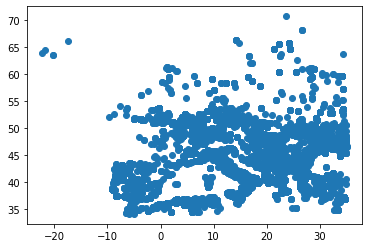

In [ ]:
paths = ProjectPath('data')
manager = RunManager(paths, 'PI')
df = manager.update_hotspots('Europe', save=False)
plt.scatter(df.longitude, df.latitude);

The `hotspots_region` name should be defined according with the image bellow. Names with multiple words use `_` in place of the spaces. More info here: https://firms.modaps.eosdis.nasa.gov/active_fire/#firms-txt

In [ ]:
IPython.display.Image(url="https://firms.modaps.eosdis.nasa.gov/images/Regions_500px.jpg")

Running all processes looks like this:

```python
region  = 'PI'
hotspots_region = 'Europe'
paths = ProjectPath('../hide/nrt_test')
weight_files = ['banetv0.20-val2017-fold0.pth', 
                'banetv0.20-val2017-fold1.pth',
                'banetv0.20-val2017-fold2.pth']
manager = RunManager(paths, region)
manager.update_hotspots(hotspots_region)
manager.download_viirs()
manager.preprocess_dataset()
manager.get_preds(weight_files)
manager.postprocess(filename=f'ba_{manager.time.strftime("%Y%m%d")}', 
                    threshold=0.5, area_epsg=3763)
```

You can easily run all this process using the console script `banet_nrt_run`.

In [ ]:
# hide
notebook2script()

Converted 00_core.ipynb.
Converted 01_geo.ipynb.
Converted 02_data.ipynb.
Converted 03_models.ipynb.
Converted 04_predict.ipynb.
Converted 04b_nrt.ipynb.
Converted 04c_historical.ipynb.
Converted 05_train.ipynb.
Converted 06_cli.ipynb.
Converted 07_web.ipynb.
Converted index.ipynb.
Converted tutorial.australia2020.ipynb.
Converted tutorial.australia2020_100m.ipynb.
